# Exploratory Data Analysis - Indiana 



In [1]:
#Import Statements
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [21]:
fname = "../clean_data/opioid_data_indiana_2006-2016.csv" 
df = pd.read_csv(fname, dtype={'fips': str, 'fips_state': str} )
df.sort_values('fips').head()

,Unnamed: 0,county,fips,state_abbrv,state,fips_state,year,population,prescription_rate,age_adjusted_mortality_range,avg_mortality_rate,change_mortality_rate,change_prescription_rate,latitude,longitude
0,0,"Adams, IN",18001,IN,Indiana,18,2006,33887,64.1,4-5.9,4.95,NaN,NaN,40.746298,-84.956258
1,1,"Adams, IN",18001,IN,Indiana,18,2007,33962,66.3,6-7.9,6.95,2.0,2.2,40.746298,-84.956258
2,2,"Adams, IN",18001,IN,Indiana,18,2008,34214,68.4,6-7.9,6.95,0.0,2.1,40.746298,-84.956258
3,3,"Adams, IN",18001,IN,Indiana,18,2009,34351,68.6,6-7.9,6.95,0.0,0.2,40.746298,-84.956258
4,4,"Adams, IN",18001,IN,Indiana,18,2010,34455,65.7,8-9.9,8.95,2.0,-2.9,40.746298,-84.956258


In [3]:
year = df['year']
prescription = df['prescription_rate']
mortality = df['avg_mortality_rate']

In [4]:
annual_prescription= df.groupby('year')['prescription_rate'].mean().values
annual_mortality = df.groupby('year')['avg_mortality_rate'].mean()
tiny_year = df.year.unique()

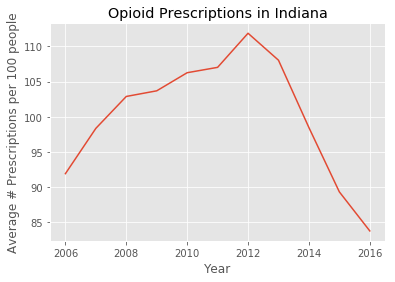

In [5]:
#Creating our graph of Pr
plt.clf()
plt.plot(tiny_year, annual_prescription)
plt.xlabel('Year')
plt.ylabel('Average # Prescriptions per 100 people')
plt.title('Opioid Prescriptions in Indiana')
plt.show()

It looks like there was a sharp decrease in opioid prescriptions in Indiana. After talking with Dr. Kosali Simon, this was due to a reformulation of the drug around this time. Given that this was the height of the prescription time period, this will be an area where I want to identify klusters of opioid use using k-means. But for now, let's look at opioid-related deaths over the same time period:

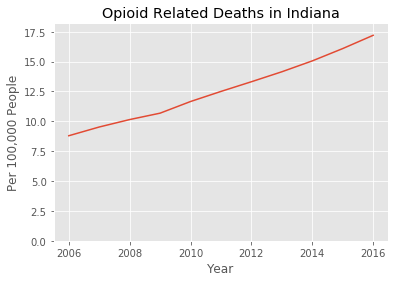

In [6]:
plt.clf()
plt.plot(tiny_year, annual_mortality)
plt.xlabel('Year')
plt.ylabel('Per 100,000 People')
plt.ylim(0, max(annual_mortality)+1)
plt.title('Opioid Related Deaths in Indiana')
plt.show()

## Regression Analysis

Given the unusual shape of the prescription data, regression analysis across the entire dataset does not seem like it would reveal much; the peak and fall might hide correlation from before and after the reformulation / guidelines in 2012. As such, I performed two regressions, one from 2006 to 2012, and one from 2012 to 2016. 

In [7]:


# Import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np 

def five_fold_regression_analysis(X, y): 
    """
    THIS FUNCTION IS ESSENTIALLY COPIED DIRECTLY FROM THE DATACAMP TUTORIAL
    I put it together into one function for reuse, but the code is not mine. 
    """

    # Create a linear regression object: reg
    reg = LinearRegression()

    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(reg, X, y, cv=5)

    # Print the 5-fold cross-validation scores
    print(cv_scores)

    # Print the average 5-fold cross-validation score
    print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))



In [8]:
pre_2012 = df[df['year'] <=2012]
post_2012 = df[df['year'] >=2012]

pre_2012_mortality = pre_2012['avg_mortality_rate'].values.reshape(-1,1)
pre_2012_prescription = pre_2012['prescription_rate'].values.reshape(-1,1)

post_2012_mortality = post_2012['avg_mortality_rate'].values.reshape(-1,1)
post_2012_prescription = post_2012['prescription_rate'].values.reshape(-1,1)

#We will treat prescription as our independent variable and opioid related mortality rates as our dependent variable
print('Pre 2012:')
five_fold_regression_analysis(pre_2012_prescription, pre_2012_mortality)

print('Post 2012: ')
five_fold_regression_analysis(post_2012_prescription, post_2012_mortality)



Pre 2012:
[-0.01699805  0.1991368   0.25072148  0.47599374  0.05145635]
Average 5-Fold CV Score: 0.19206206217475358
Post 2012: 
[-0.06966678  0.06733981 -0.06187388  0.08349046 -0.07546054]
Average 5-Fold CV Score: -0.011234185295052046


**** INTERESTING COMPARISON BETWEEN plain linear regression and using the 5-Fold CV Score. Those with the biggest drop in prescriptions are actually correlated to increase in opioid deaths. Is this because they were the ones with the highest reliance on opioid prescriptions to begin with? Most likely this is because the counties that had the biggest decreases in number of prescriptions had the highest levels of prescriptions to begin with, so when that supply dissaptes it creates a vaccuum where people seek out (deadlier) alternatives. 

As you can see, there is a significant drop in the correlation between #number of prescriptions per people and the number of opioid related-deaths.

In [41]:

## Need to Calculate Natural Breaks for use in the colorbar -- see https://github.com/mthh/jenkspy
#pip install jenkspy
import jenkspy

prescriptions_2012 = df[df['year']==2012]['prescription_rate'].values.tolist()
prescriptions_2016 = df[df['year']==2016]['prescription_rate'].values.tolist()

#mortality_2012 = df[df['year']==2012]['avg_mortality_rate'].values.tolist()
#mortality_2016 = df[df['year']==2016]['avg_mortality_rate'].values.tolist()

fips_2012 = df[df['year']==2012]['fips'].values.tolist()
#fips_2016 = df[df['year']==2016]['fips'].values.tolist()

bins_pres= jenkspy.jenks_breaks(prescriptions_2012, nb_class=5)
#bins_mort = jenkspy.jenks_breaks(mortality_2016, nb_class=5)
print(bins_pres)

[26.2, 72.7, 103.6, 131.5, 165.4, 237.4]
[6.95, 10.95, 14.95, 18.95, 24.95, 30.0]


In [39]:
import plotly.plotly as py
import plotly.figure_factory as ff

import numpy as np
import pandas as pd

"""
The following dependencies must be install for this code to work
pip install plotly
pip install geopandas==0.3.0
pip install pyshp==1.2.10
pip install shapely==1.6.3

This code was taken from the plotly tutorial 'Python USA County Choropleth Maps' and modified to fit my dataset.

View the original tutorial at: https://plot.ly/python/county-choropleth/

"""

fig = ff.create_choropleth(
    fips=fips_2012, values=prescriptions_2012, scope=['IN', 'IL', 'OH'],
    binning_endpoints=bins_pres, 
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='# Prescriptions per 100 People', title='2012 Opioid Prescription Rates in Indiana'
)
py.iplot(fig, filename='choropleth_2012_opioid_prescriptions_indiana')


/Users/mae/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [59]:
df.head()

df_change = df[df['year']>=2012]

df_change = df_change.groupby(['fips']).agg({'change_prescription_rate': np.sum, 'change_mortality_rate': np.sum}) 
print(df_change.head())

fips_change = df_change.index.values.tolist()
change_prescription_rate = df_change.change_prescription_rate.values.tolist()
change_mortality_rate = df_change.change_mortality_rate.values.tolist()

bins_pres_change = jenkspy.jenks_breaks(change_prescription_rate, nb_class=5)
bins_mort_change = jenkspy.jenks_breaks(change_mortality_rate, nb_class=5)
print(bins_pres_change)

       change_prescription_rate  change_mortality_rate
fips                                                  
18001                      -4.1                    4.0
18003                     -13.7                    4.0
18005                     -57.3                    4.0
18007                      -5.3                    8.0
18009                     -45.6                    8.0
[-89.80000000000001, -70.29999999999998, -38.89999999999999, -21.799999999999997, -10.700000000000003, 1.9000000000000057]


In [61]:
fig = ff.create_choropleth(
    fips=fips_change, values=change_prescription_rate, scope=['IN', 'IL', 'OH'],
    binning_endpoints=bins_pres_change, 
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Change in # Prescriptions per 100 People', title='2012 to 2016: Change in Opioid Prescriptions'
)
py.iplot(fig, filename='choropleth_change_opioid_prescriptions_indiana')


/Users/mae/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [62]:
fig = ff.create_choropleth(
    fips=fips_change, values=change_mortality_rate, scope=['IN', 'IL', 'OH'],
    binning_endpoints=bins_mort_change, 
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Change in Opioid Related Deaths per 100,000 People', title='2012 to 2016: Change in Opoid Mortality Rates'
)
py.iplot(fig, filename='choropleth_change_opioid_prescriptions_indiana')


/Users/mae/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## U.S. 

In [14]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='middaugh', api_key='8Mr0AldZkf8BpDzGMMQT')
import plotly.graph_objs as go

import pandas as pd

usa_df = pd.read_csv('../clean_data/opioid_data_2006-2016.csv')
usa_df = df[df.year==2012]


for col in usa_df.columns:
    usa_df[col] = df[col].astype(str)

scl = [
    [0.0, 'rgb(242,240,247)'],
    [0.05, 'rgb(218,218,235)'],
    [0.1, 'rgb(188,189,220)'],
    [0.15, 'rgb(158,154,200)'],
    [0.2, 'rgb(117,107,177)'],
    [1, 'rgb(84,39,143)']
]

usa_df['text'] = usa_df['state'] + '<br>' + \
    'Opioid rate:' + usa_df['avg_mortality_rate'] + ' <br> Prescription: ' + usa_df['prescription_rate'] \
    + '<br> Year: ' + usa_df['year']

data = [go.Choropleth(
    colorscale = scl,
    autocolorscale = False,
    locations = usa_df['state_abbrv'],
    z = df['prescription_rate'].astype(float),
    locationmode = 'USA-states',
    text = df['text'],
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(255,255,255)',
            width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        title = "Number of Opioid Prescriptions per 100 People")
)]

layout = go.Layout(
    title = go.layout.Title(
        text = 'Opioid Prescription Rate in 2012'
    ),
    geo = go.layout.Geo(
        scope = 'usa',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)'),
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'd3-cloropleth-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~middaugh/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [ ]:
df.head()

References
 - https://plot.ly/python/county-choropleth/
 - The AGC2 Proposal 

In [ ]:
us_prescription_cumul = df.groupby('year')['prescription_rate'].mean().values
us_mortality_cumul = df.groupby('year')['avg_mortality_rate'].mean().values 

In [ ]:
def overall_change(x, y, xlabel = 'REPLACE WITH X LABEL', ylabel= 'REPLACE WITH Y LABEL', \
                   title='REPLACE WITH TITLE'):
    plt.clf()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0, max(y) + 1 )
    plt.title(title)
    plt.show()

In [ ]:
us_prescription_change = overall_change(tiny_year, annual_prescription, xlabel = 'Year', \
                                        ylabel = 'Average # Prescriptions per 100 people', 
                                       title = 'Opioid Prescriptions in the US')

In [ ]:
us_mortality_change = overall_change(tiny_year, annual_mortality, xlabel = 'Year', \
                                        ylabel = '#Opioid Related Deaths per 100,000 people', 
                                       title = 'Opioid Related Deaths in the US')